# Interstellar - Emotion Analysis
![Changing Emotion](https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/images/interstellar.png)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/04-movie-analysis-interstellar.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/04-movie-analysis-interstellar.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/04-movie-analysis-interstellar.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

[EVA](https://github.com/georgia-tech-db/eva) is a database system for video analytics that uses an SQL-like interface to query videos. EVA packages various computer vision models and traditional database systems principles into a single system that accelerates video analytics.

In this notebook, we show how to use EVA to analyze emotions in movies. We analyze the famous 5 minute scene `Years of Messages` from the movie Intersetallar to detect the varying emotions of the actors as the scene progresses.

## Start EVA Server
We first initialize and launch the Eva server using the start server notebook. We then estabish a connection to the launched server.

In [1]:
!wget -nc -q --show-progress "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

Note: you may need to restart the kernel to use updated packages.


sh: 1: kill: Usage: kill [-s sigspec | -signum | -sigspec] [pid | job]... or
kill -l [exitstatus]
rm: cannot remove 'nohup.out': No such file or directory
cat: nohup.out: No such file or directory
22/09/29 14:21:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
09-29-2022 14:21:31 CRITICAL[server:server.py:start_server:0098] Start Server
09-29-2022 14:21:31 CRITICAL[server:server.py:start_server:0117] PID(13801) serving on ('0.0.0.0', 5432)


Note: you may need to restart the kernel to use updated packages.


## Downloading necessary files
EVA leverages existing computer vision models in the form of user-defined functions (UDFs) that can be directly imported and used to process videos.
Here, we download the video file and the necessary UDF definition files for this task - (1) face detector and (2) emotion detector.

In [3]:
# Link for movie_clip
!wget -nc -q --show-progress https://www.dropbox.com/s/xdlnctyry1p3xwr/interstellar.mp4

# Links for UDFs
!wget -nc -q --show-progress https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/face_detector.py
!wget -nc -q --show-progress https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/emotion_detector.py

interstellar.mp4    100%[===================>]  21.35M  33.0MB/s    in 0.6s    
face_detector.py    100%[===================>]   2.24K  --.-KB/s    in 0s      
emotion_detector.py 100%[===================>]   5.28K  --.-KB/s    in 0s      


## Visualize Video Clip

In [ ]:
from IPython.display import Video
Video("interstellar.mp4", height=450, width=800, embed=True)

## Loading the video files in EVA
Loading the video files into EVA can be done in the single line command as shown. This command creates the table named `interstellar` in the EVA database and also generates the necessary metadata.

In [4]:
# Adding the movies to eva
cursor.execute('drop table if exists interstellar')
response = cursor.fetch_all()

cursor.execute('load file "interstellar.mp4" into interstellar')
response = cursor.fetch_all()
print(response.batch.frames[0][0])

Video successfully added at location: interstellar.mp4


09-29-2022 14:21:54 ERROR [binder_utils:binder_utils.py:bind_table_info:0121] interstellar does not exist. Create the table using CREATE TABLE.
09-29-2022 14:21:54 WARNING[command_handler:command_handler.py:handle_request:0075] interstellar does not exist. Create the table using CREATE TABLE.


## Defining the User-Defined Functions (UDF)

As described earlier, EVA uses UDFs to perform computer vision tasks. Here, we create the UDFs inside the EVA database using the UDF definition files that we downloaded earlier.

In [6]:
# Defining the UDFs
cursor.execute("""CREATE UDF IF NOT EXISTS EmotionDetector 
        INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM)) 
        OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM)) 
        TYPE  Classification IMPL 'emotion_detector.py';
        """)
response = cursor.fetch_all()
print(response.batch.frames[0][0])
cursor.execute("""CREATE UDF IF NOT EXISTS FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """)
response = cursor.fetch_all()
print(response.batch.frames[0][0])

UDF EmotionDetector already exists, nothing added.
UDF FaceDetector already exists, nothing added.


09-29-2022 14:22:07 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF EmotionDetector already exists, nothing added.
09-29-2022 14:22:07 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FaceDetector already exists, nothing added.


## Extract Emotions of all the faces in the movie clip

Now that we have created the UDFs and loaded our video into EVA, we are ready to run some queries on the video and see the magic happen. Using the below query, we can find all the faces and their respective emotions in the video sequence.

In [7]:
cursor.execute(f"""SELECT id, Face.bbox, Emotion.label 
                   FROM  interstellar 
                      JOIN LATERAL  Unnest(FaceDetector(data)) AS Face(bbox, conf) 
                      JOIN LATERAL EmotionDetector(Crop(data, bbox)) AS Emotion (label, conf)
                   WHERE Face.conf > 0.75 AND Emotion.conf > 0.5;
                """
               )
response = cursor.fetch_all()
print("Total emotions detected: {}".format(len(response.batch)))

Total emotions detected: 5919


## Visualizing the distribution of emotions

Here, we show the distribution of the different emotions that EVA found in the scene. We see that a wide range of emotions are displayed within a span of 5 minutes such as happiness, sadness, and fear.

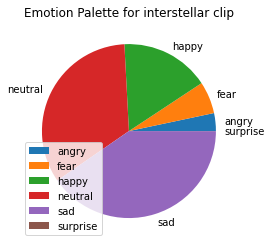

In [8]:
df = response.batch.frames
ax = df.groupby(['Emotion.label']).count().plot(kind='pie', y = 'interstellar.id', title="Emotion Palette for interstellar clip");
ax.set_ylabel("");
ax.legend(loc='lower left');

## Identify instances with changing emotions

We next use the output of EVA to measure the instances where the emotions change from the previous shot to the next shot. We see that the actor's emotions change rapidly between happiness, sadness, neutral, and fear several times. This shows the range of the actor's emotions in this particular scene.

In [9]:
import numpy as np
emotions = df['Emotion.label'].to_numpy()
ids = df['interstellar.id'].to_numpy()

data = zip(ids, emotions)
from itertools import groupby
emotes = [list(j) for i, j in groupby(data, lambda x: x[1])]
emotion_groups = []
for item in emotes:
    start = item[0][0]
    end = item[-1][0]
    emote = item[0][1]
    if (end - start > 50):
        emotion_groups.append((start, end, emote))
prev = emotion_groups[0]
changing_emotions = set()
for item in emotion_groups[1:]:
    if item[2] != prev[2]:
        changing_emotions.add(prev)
        changing_emotions.add(item)
    prev = item
change_idxs = sorted([np.random.randint(a,b) for a,b, _ in changing_emotions])

In [10]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
import ast

def img_show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

def view_frames(video_path, frame_data, id_name):
    color1=(207, 248, 64)
    color2=(0, 0, 255)
    thickness=4
    
    vcap = cv2.VideoCapture(video_path)
    frame_id = 0
    ret, frame = vcap.read()
    while ret:
        df = frame_data[frame_data[id_name] == frame_id]
        img = frame
        if df.size:
            label = df['Emotion.label'].tolist()[0]
            x1,y1,x2,y2 = df['Face.bbox'].tolist()[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(img, 'Frame ID: ' + str(frame_id), (900, 1000), cv2.FONT_HERSHEY_SIMPLEX, 2.4, color2, thickness) 
           
            img_show(img)
            
        frame_id +=1
        ret,frame = vcap.read()
    vcap.release()

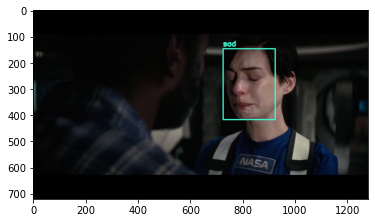

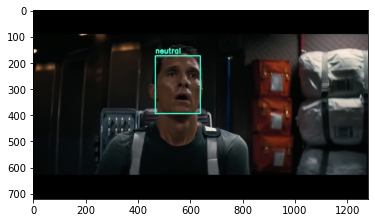

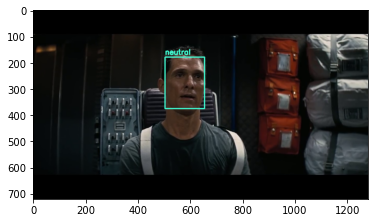

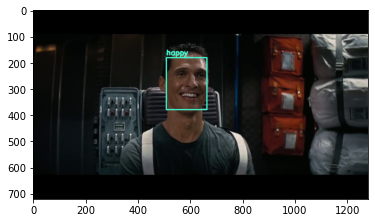

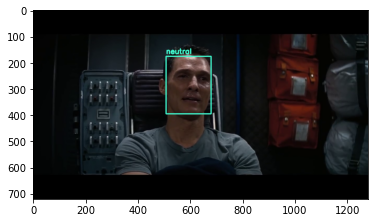

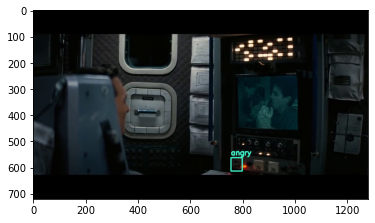

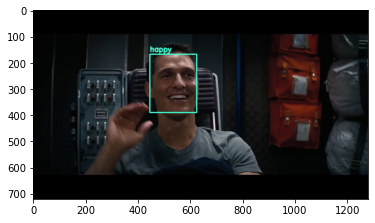

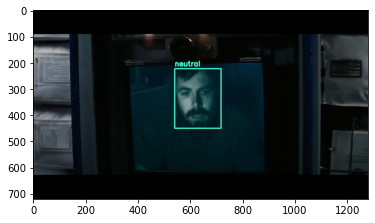

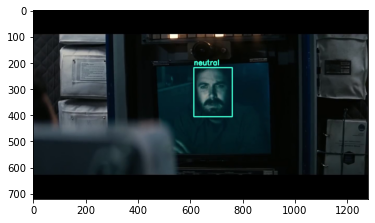

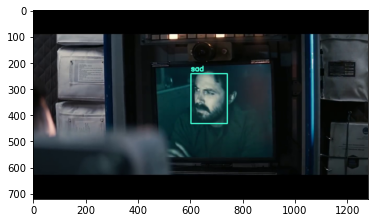

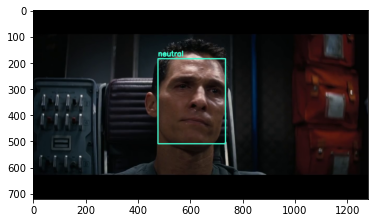

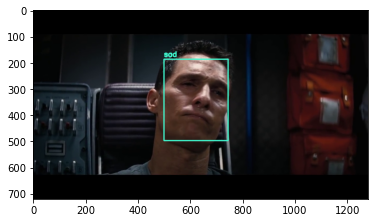

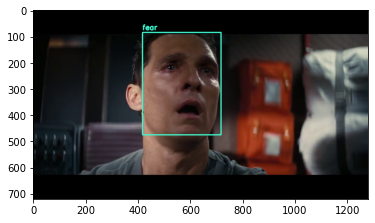

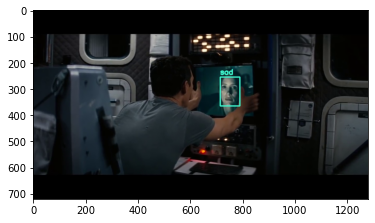

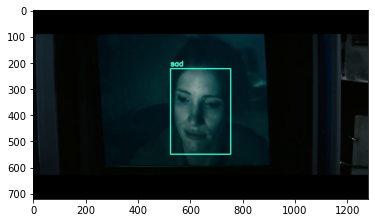

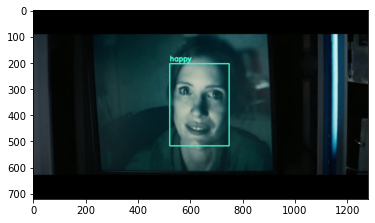

In [11]:
interesting_frames = df.loc[df['interstellar.id'].isin(change_idxs)]
input_path = f'./interstellar.mp4'
id_name = f'interstellar.id'
view_frames(input_path, interesting_frames, id_name)